In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedKFold 
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import describe

/home/sirorezka/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

print(df_test.shape)
print(df_train.shape)

(75818, 370)
(76020, 371)


In [3]:
# remove constant columns
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

print(df_test.shape)
print(df_train.shape)

(75818, 336)
(76020, 337)


In [4]:
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,39205.170000,0
1,3,2,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49278.030000,0
2,4,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,67333.770000,0
3,8,2,37,0,195,195,0,0,0,0,...,0,0,0,0,0,0,0,0,64007.970000,0
4,10,2,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,117310.979016,0


In [5]:
# remove duplicated columns
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

y_train = df_train['TARGET'].values
X_train = df_train.drop(['ID','TARGET'], axis=1).values

id_test = df_test['ID']
X_test = df_test.drop(['ID'], axis=1).values

print(df_test.shape)
print(df_train.shape)

(75818, 307)
(76020, 308)


In [6]:
# Adding log features

c = X_train.shape[1]

for i in range(c):
    if sum(X_train[:,i]<0)==0:
        new_col = np.log(X_train[:,i]+1)
        X_train = np.column_stack((X_train, new_col))
        
        new_col = np.log(X_test[:,i]+1)
        X_test = np.column_stack((X_test, new_col))
        
print(X_test.shape)
print(X_train.shape)

(75818, 584)
(76020, 584)


In [7]:
## Feature selection

clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
feature_selected = clf.feature_importances_

print ("ExtraTrees done")

ExtraTrees done


In [8]:
feature_selected = np.argsort(-feature_selected)
print (feature_selected[0:30])

[583 305 306   1 268 270 552 510 356 266 264 267 550 263 549 150 128 143
 269 507 265 221 551 509 223 504 152 505 218 233]


In [9]:
# length of dataset
len_train = len(X_train)
len_test  = len(X_test)

In [10]:
# classifier
clf = xgb.XGBClassifier(missing=np.nan, max_depth=3, n_estimators=350, learning_rate=0.03, nthread=8, subsample=0.95, colsample_bytree=0.85, seed=4242)

X_fit, X_eval, y_fit, y_eval = train_test_split(X_train, y_train, test_size=0.5, random_state = 84)

# fitting
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])

print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]), roc_auc_score(y_eval, clf.predict_proba(X_eval)[:,1]))

('Overall AUC:', 0.85571777092748369, 0.85805232177375146)


In [ ]:
## Learning with cross_validation

skf = StratifiedKFold (y_train,n_folds=5, random_state = 48)

rc_eval_dt = []
for fit_index, test_index in skf:
        # print("TRAIN:", fit_index, "TEST:", test_index)
        X_fit, X_eval = X_train[fit_index], X_train[test_index]
        y_fit, y_eval = y_train[fit_index], y_train[test_index]
        
        clf.fit(X_fit, y_fit, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])
        
        rc_fit  = roc_auc_score(y_fit, clf.predict_proba(X_fit)[:,1])
        rc_eval = roc_auc_score(y_eval, clf.predict_proba(X_eval)[:,1])
        rc_train  = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        
        rc_eval_dt.append(rc_eval)
        print (rc_fit,rc_eval,rc_train)

rc_eval_dt = np.array(rc_eval_dt)
print ("\n")
print ("results: ", rc_eval_dt.min(),rc_eval_dt.max(),rc_eval_dt.mean())

(0.82925183744912734, 0.81684513695019678, 0.82676223764149526)
(0.8387333682605963, 0.81403982661370033, 0.83378117410530594)

In [54]:
d_var = [50,75,100,125,150,175,200,225,250,275,300,325]

for d in d_var:
    skf = StratifiedKFold (y_train,n_folds=5, random_state = 48)

    rc_eval_dt = []
    for fit_index, test_index in skf:

            # print("TRAIN:", fit_index, "TEST:", test_index)
            X_fit, X_eval = X_train[fit_index][:,feature_selected[0:d]], X_train[test_index][:,feature_selected[0:d]]
            y_fit, y_eval = y_train[fit_index], y_train[test_index]
            
            clf = xgb.XGBClassifier(missing=np.nan, max_depth=3, n_estimators=550, learning_rate=0.03, nthread=8, subsample=0.95, colsample_bytree=0.85, seed=4242)
            clf.fit(X_fit, y_fit, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])    
            
            rc_fit  = roc_auc_score(y_fit, clf.predict_proba(X_fit)[:,1])
            rc_eval = roc_auc_score(y_eval, clf.predict_proba(X_eval)[:,1])
            rc_train  = roc_auc_score(y_train, clf.predict_proba(X_train[:,feature_selected[0:d]])[:,1])
            rc_eval_dt.append(rc_eval)
            
            print (rc_fit,rc_eval,rc_train)

    rc_eval_dt = np.array(rc_eval_dt)

    #print ("\n")
    print ("results: ",d," -- ",rc_eval_dt.min(),rc_eval_dt.max(),rc_eval_dt.mean())

(0.84102413033826429, 0.82034507768507958, 0.83689119915510835)
(0.81075188369480466, 0.78574528330432247, 0.80579093499713261)
(0.84164538007261702, 0.82706534307183155, 0.83872565559756418)
(0.83913052632043139, 0.84390634610944959, 0.84009047377886592)
(0.83582484303791516, 0.8212406113993912, 0.83291238748934882)
('results: ', 50, ' -- ', 0.78574528330432247, 0.84390634610944959, 0.81966053231401492)
(0.84717482674806699, 0.82340200882583858, 0.8424236459672616)
(0.84862963719294959, 0.81341088835566722, 0.84160123033549716)
(0.81017486031539887, 0.8036822880950637, 0.80886967647987928)
(0.84612920271134662, 0.84715784380732384, 0.84632983677413565)
(0.84175033911748165, 0.82272492018393306, 0.83797457678918419)
('results: ', 75, ' -- ', 0.8036822880950637, 0.84715784380732384, 0.82207558985356532)
(0.84541888927347497, 0.82520419164769088, 0.8413627822109685)
(0.82211044535078082, 0.8013886010315544, 0.81799022162343471)
(0.8485599795238834, 0.8341605801053058, 0.8456758073723819)

In [59]:
# predicting

d = 250
X_fit, X_eval, y_fit, y_eval = train_test_split(X_train, y_train, test_size=0.5, random_state = 84)

X_fit   =   X_fit[:,feature_selected[0:d]]
X_eval  =   X_eval[:,feature_selected[0:d]]

clf = xgb.XGBClassifier(missing=np.nan, max_depth=3, n_estimators=550, learning_rate=0.03, nthread=8, subsample=0.95, colsample_bytree=0.85, seed=4242)
clf.fit(X_fit, y_fit, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])    


rc_fit  = roc_auc_score(y_fit, clf.predict_proba(X_fit)[:,1])
rc_eval = roc_auc_score(y_eval, clf.predict_proba(X_eval)[:,1])
rc_train  = roc_auc_score(y_train, clf.predict_proba(X_train[:,feature_selected[0:d]])[:,1])         
print (rc_fit,rc_eval,rc_train)
            
            
y_pred= clf.predict_proba(X_test[:,feature_selected[0:d]])[:,1]

submission = pd.DataFrame({"ID":id_test, "TARGET":y_pred})
submission.to_csv("predictions/submission_xgb.csv", index=False)

print('Completed!')

(0.85156627935341822, 0.8313849956150241, 0.8413412655096919)
Completed!


In [60]:
print (sum(y_fit==1)*1.0/len(y_fit))
print (len(y_fit), sum(y_fit==1))
print (sum(y_eval==1)*1.0/len(y_eval))
print (len(y_eval), sum(y_eval==1))

0.0389634306761
(38010, 1481)
0.0401736385162
(38010, 1527)


In [77]:
X_train.max(axis=1)

array([  39205.17      ,   49278.03      ,   67333.77      , ...,
         74028.15      ,   84278.16      ,  117310.97901649])

In [78]:
X_train.min(axis=1)

array([ 0., -1.,  0., ...,  0.,  0.,  0.])

0.0 72564 2977
0.69 3456 31


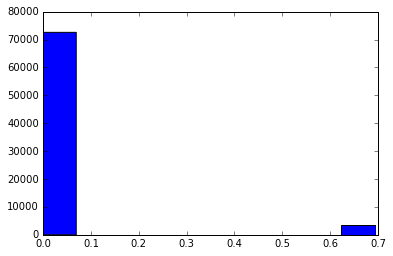

In [282]:
%matplotlib inline  
import matplotlib.pyplot as plt

data_plt = X_train[:,28]
data_plt = data_plt[data_plt>=0]            
data_plt = np.log(data_plt+1)
#data_plt = data_plt[data_plt<25]
plt = hist(data_plt,10)

for j in unique(data_plt):
    print round(j,2), sum(data_plt==j), sum(y_train[data_plt==j])